In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

### Using XGBoost Algorithm

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
df.shape

(1470, 35)

Checking for Null Values

In [4]:
print(df.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Drop columns with constant values

In [5]:
df = df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [6]:
df.shape

(1470, 32)

Handling Duplicate Values

In [7]:
print("duplicate rows:", df.duplicated().sum())
print('Before Duplicates-',df.shape)
df = df.drop_duplicates()
print('After Duplicates-',df.shape)

duplicate rows: 0
Before Duplicates- (1470, 32)
After Duplicates- (1470, 32)


Converting Categorical to Numerical Data

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns
le = LabelEncoder()

for i in categorical_columns:
    df[i] = le.fit_transform(df[i])

Renaming the target column from Attrition to Churn

In [9]:
df = df.rename(columns={'Attrition': 'Churn'})

Feature Engineering

In [10]:
df['TotalSatisfaction'] = df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['RelationshipSatisfaction']

Scaling the dataset using Min Max Scaler

In [11]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
mm = MinMaxScaler()
df[numerical_columns] = mm.fit_transform(df[numerical_columns])

Data Visualization after Scaling

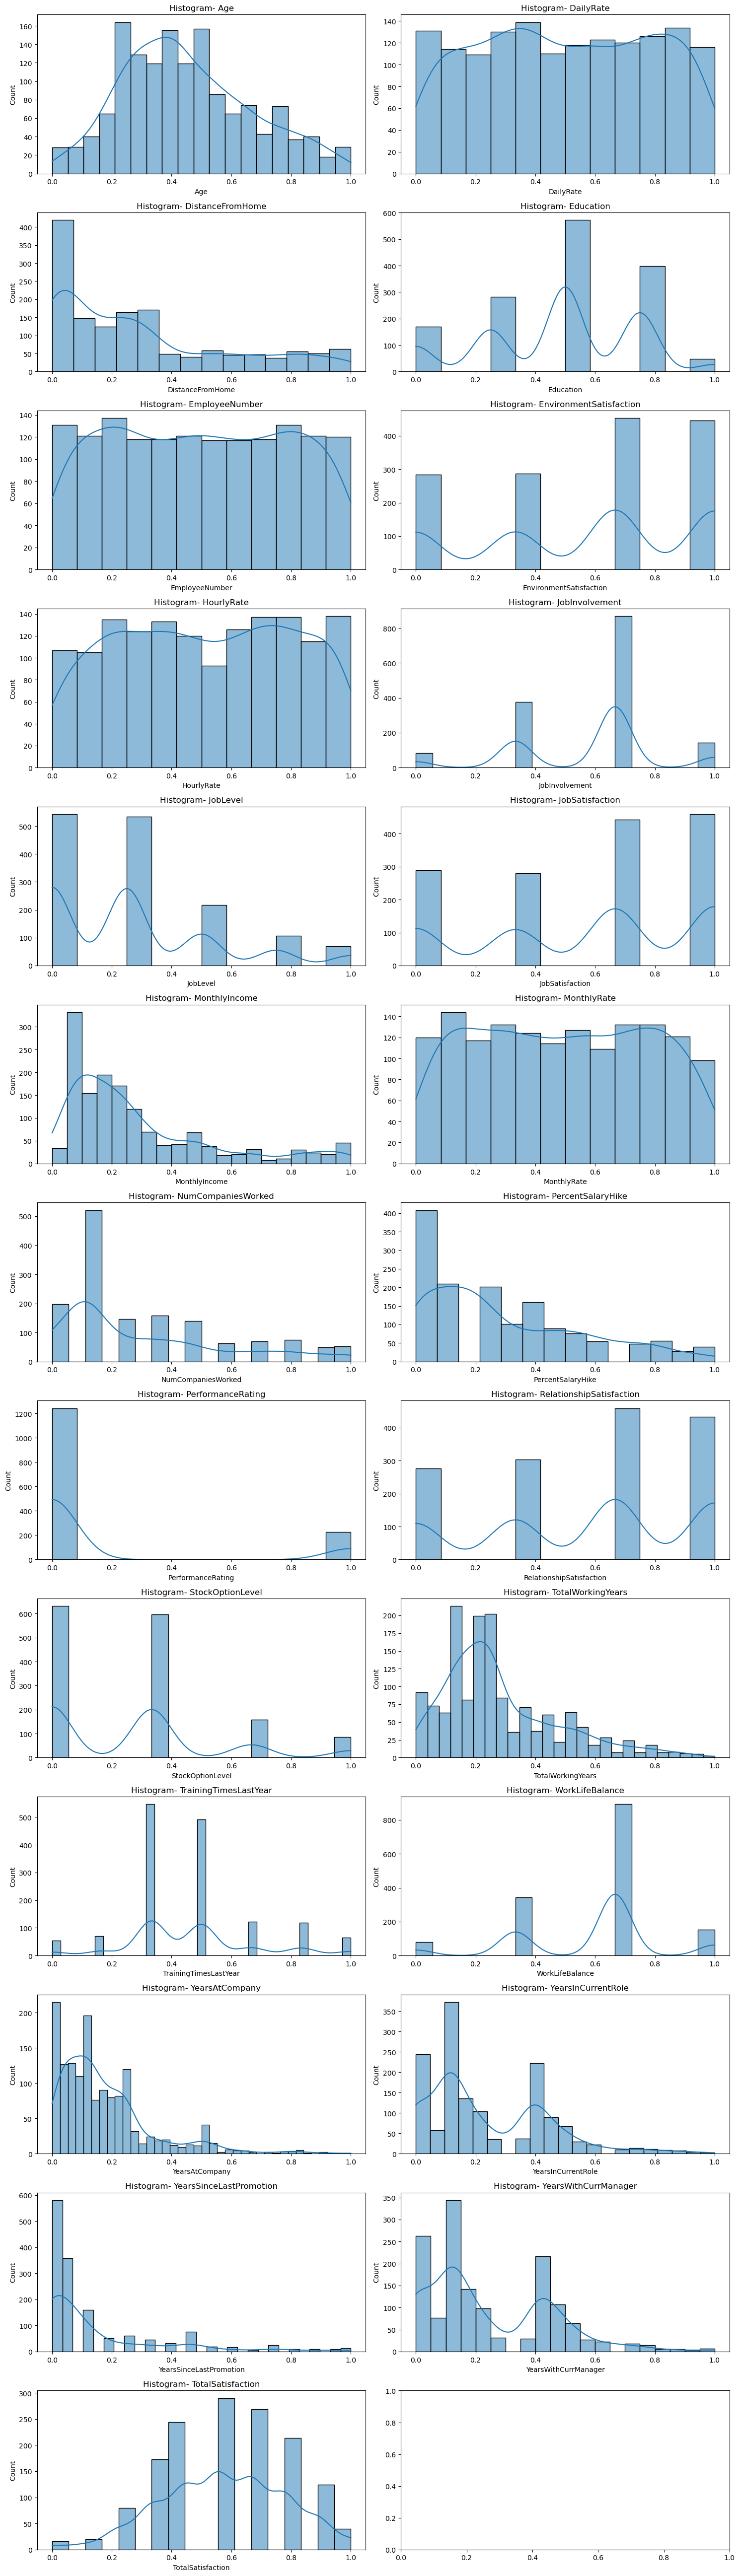

In [12]:
num_rows = (len(numerical_columns) + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

for i, column in enumerate(numerical_columns):
    sns.histplot(df[column], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Histogram- {column}')
    
plt.tight_layout()
plt.show()

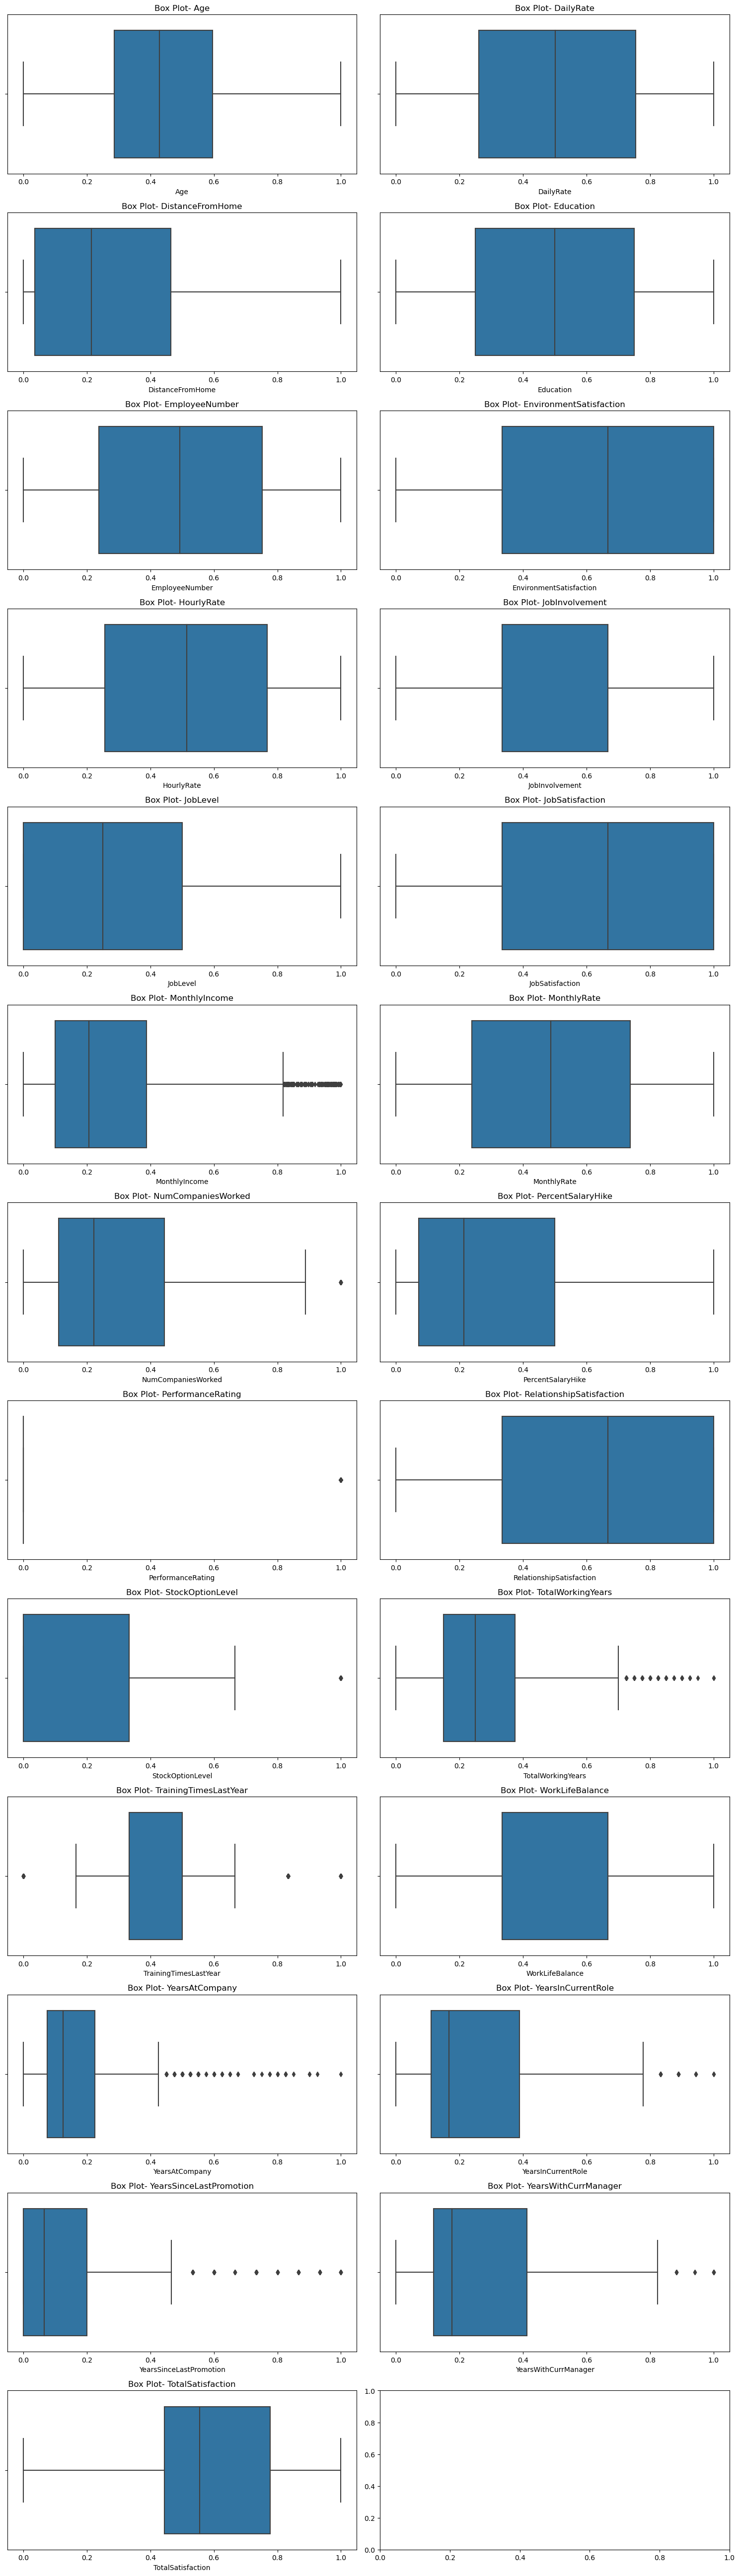

In [13]:
fig, axes = plt.subplots(num_rows,2, figsize=(15, 4 * num_rows))

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Box Plot- {column}')

plt.tight_layout()
plt.show()

<Figure size 1500x1200 with 0 Axes>

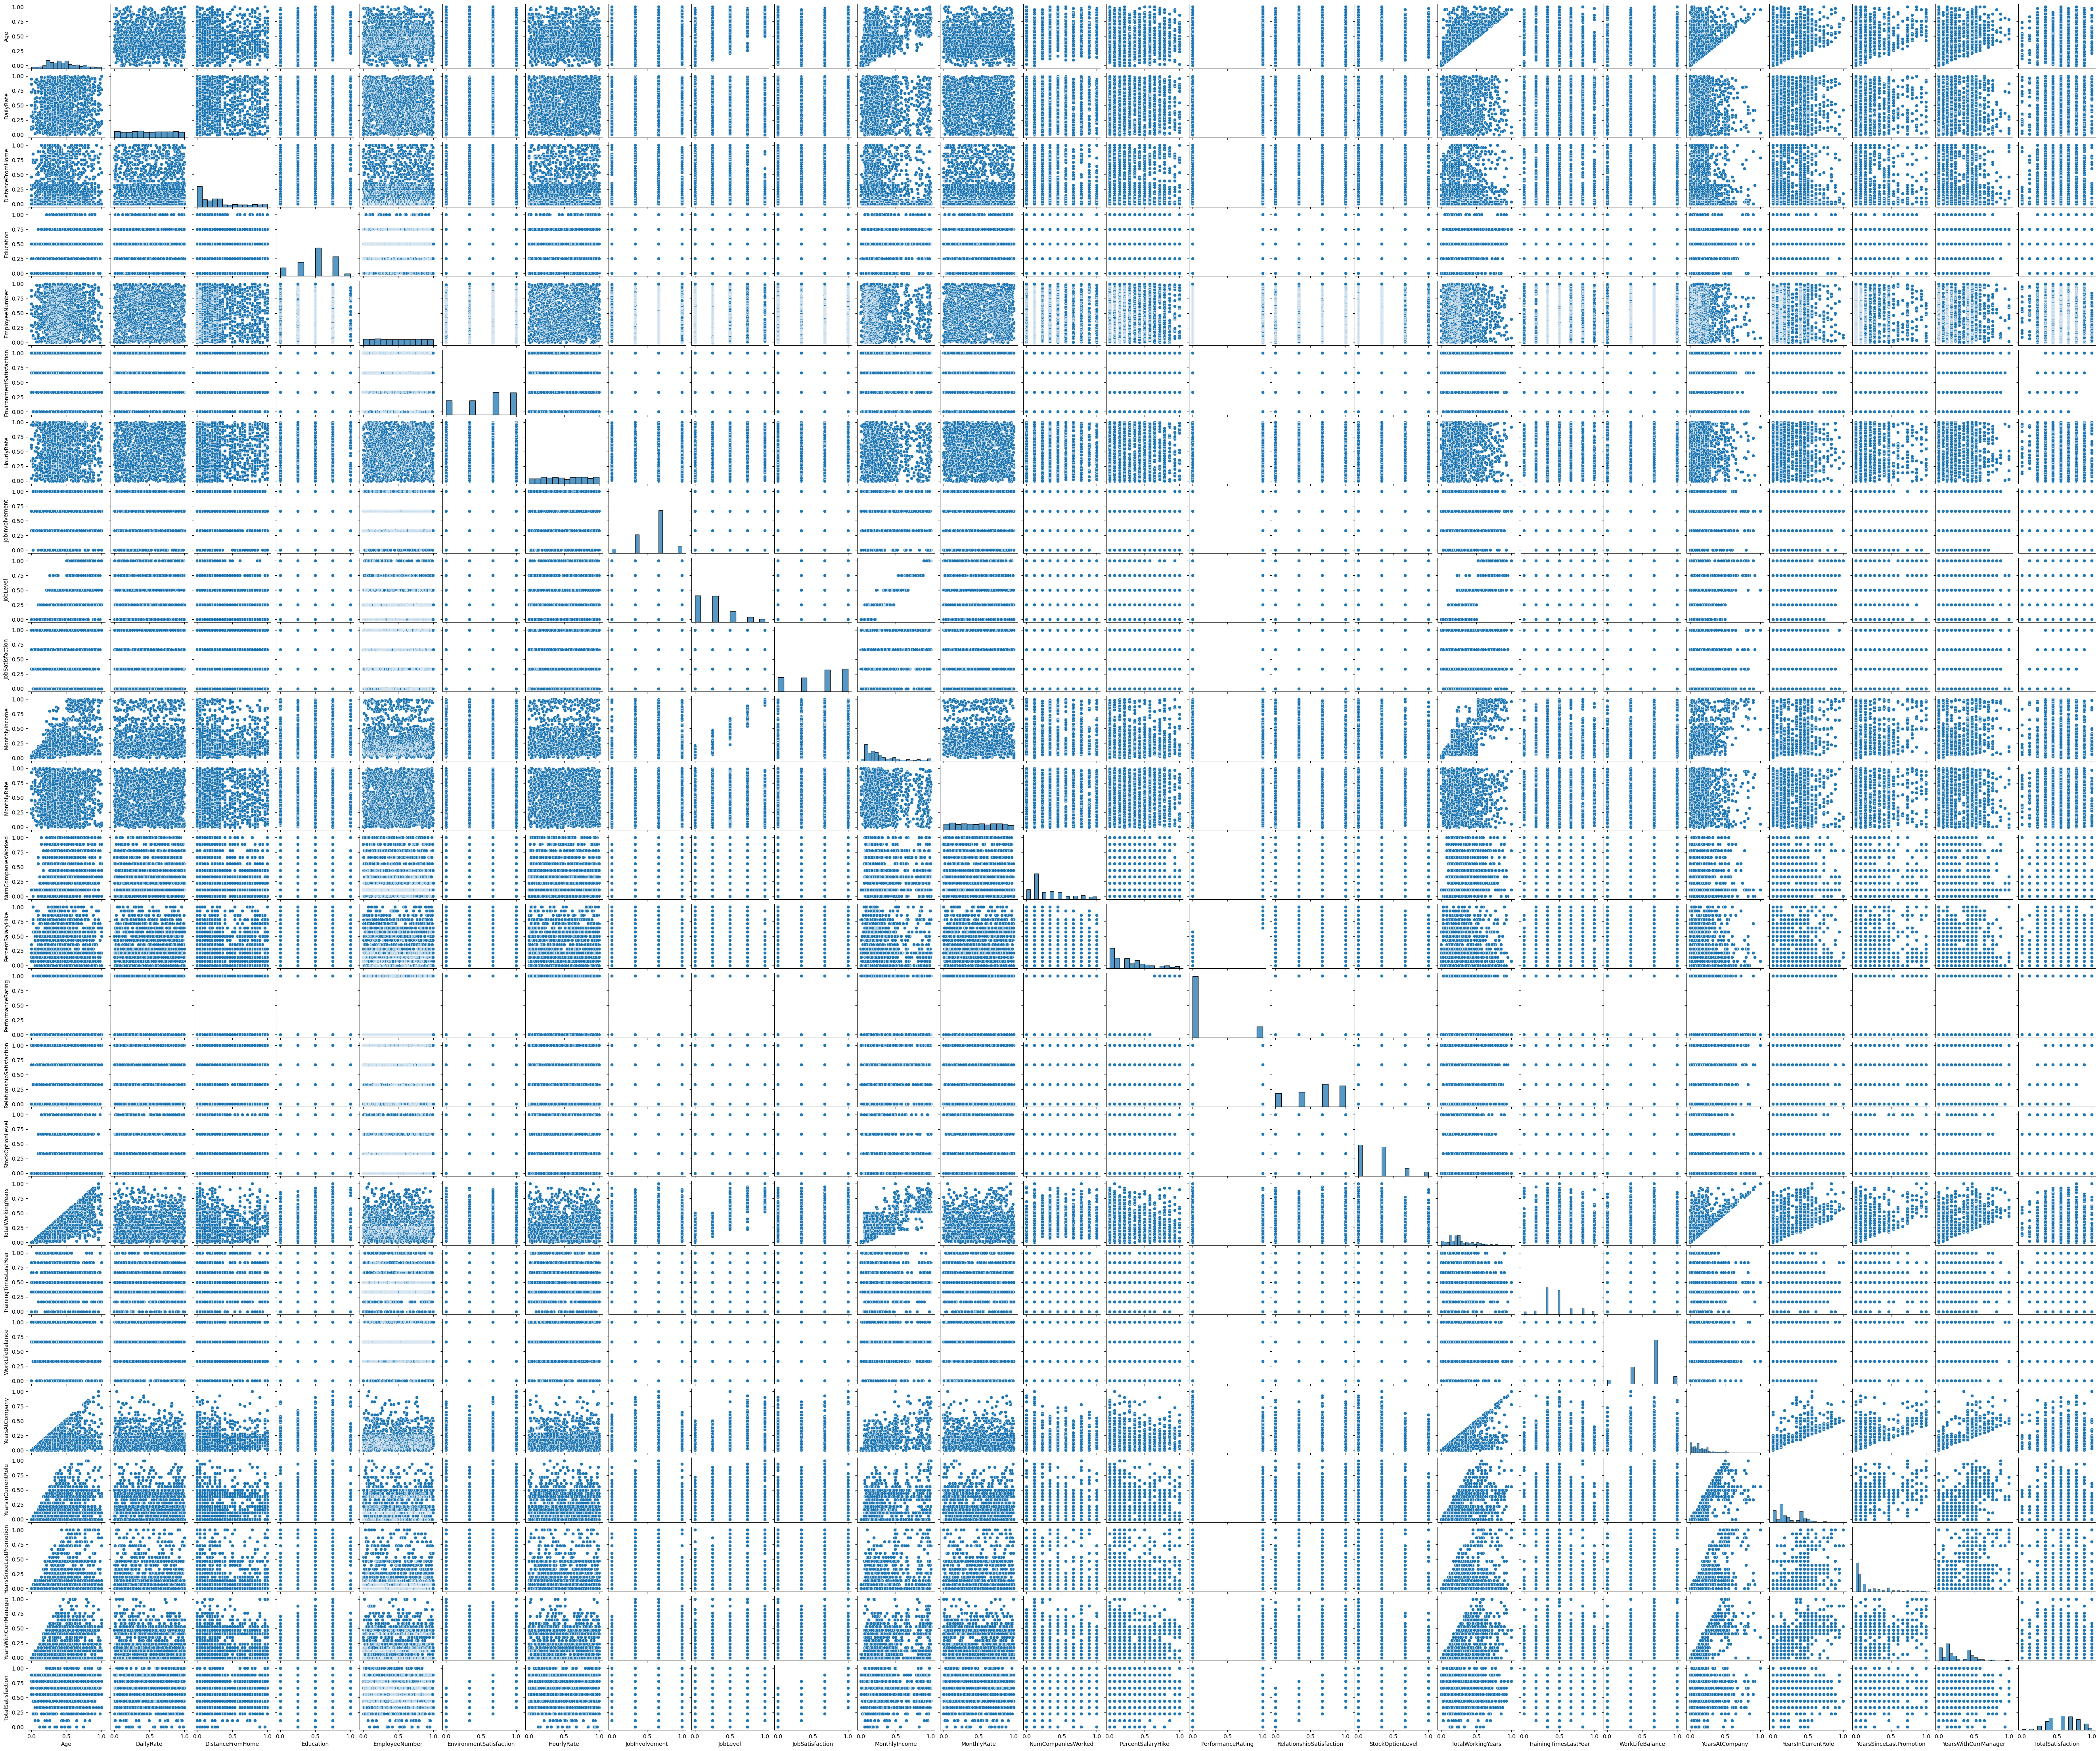

In [14]:
plt.figure(figsize=(15, 12))
sns.pairplot(df[numerical_columns], height=1.8, aspect=1.2)
plt.show()


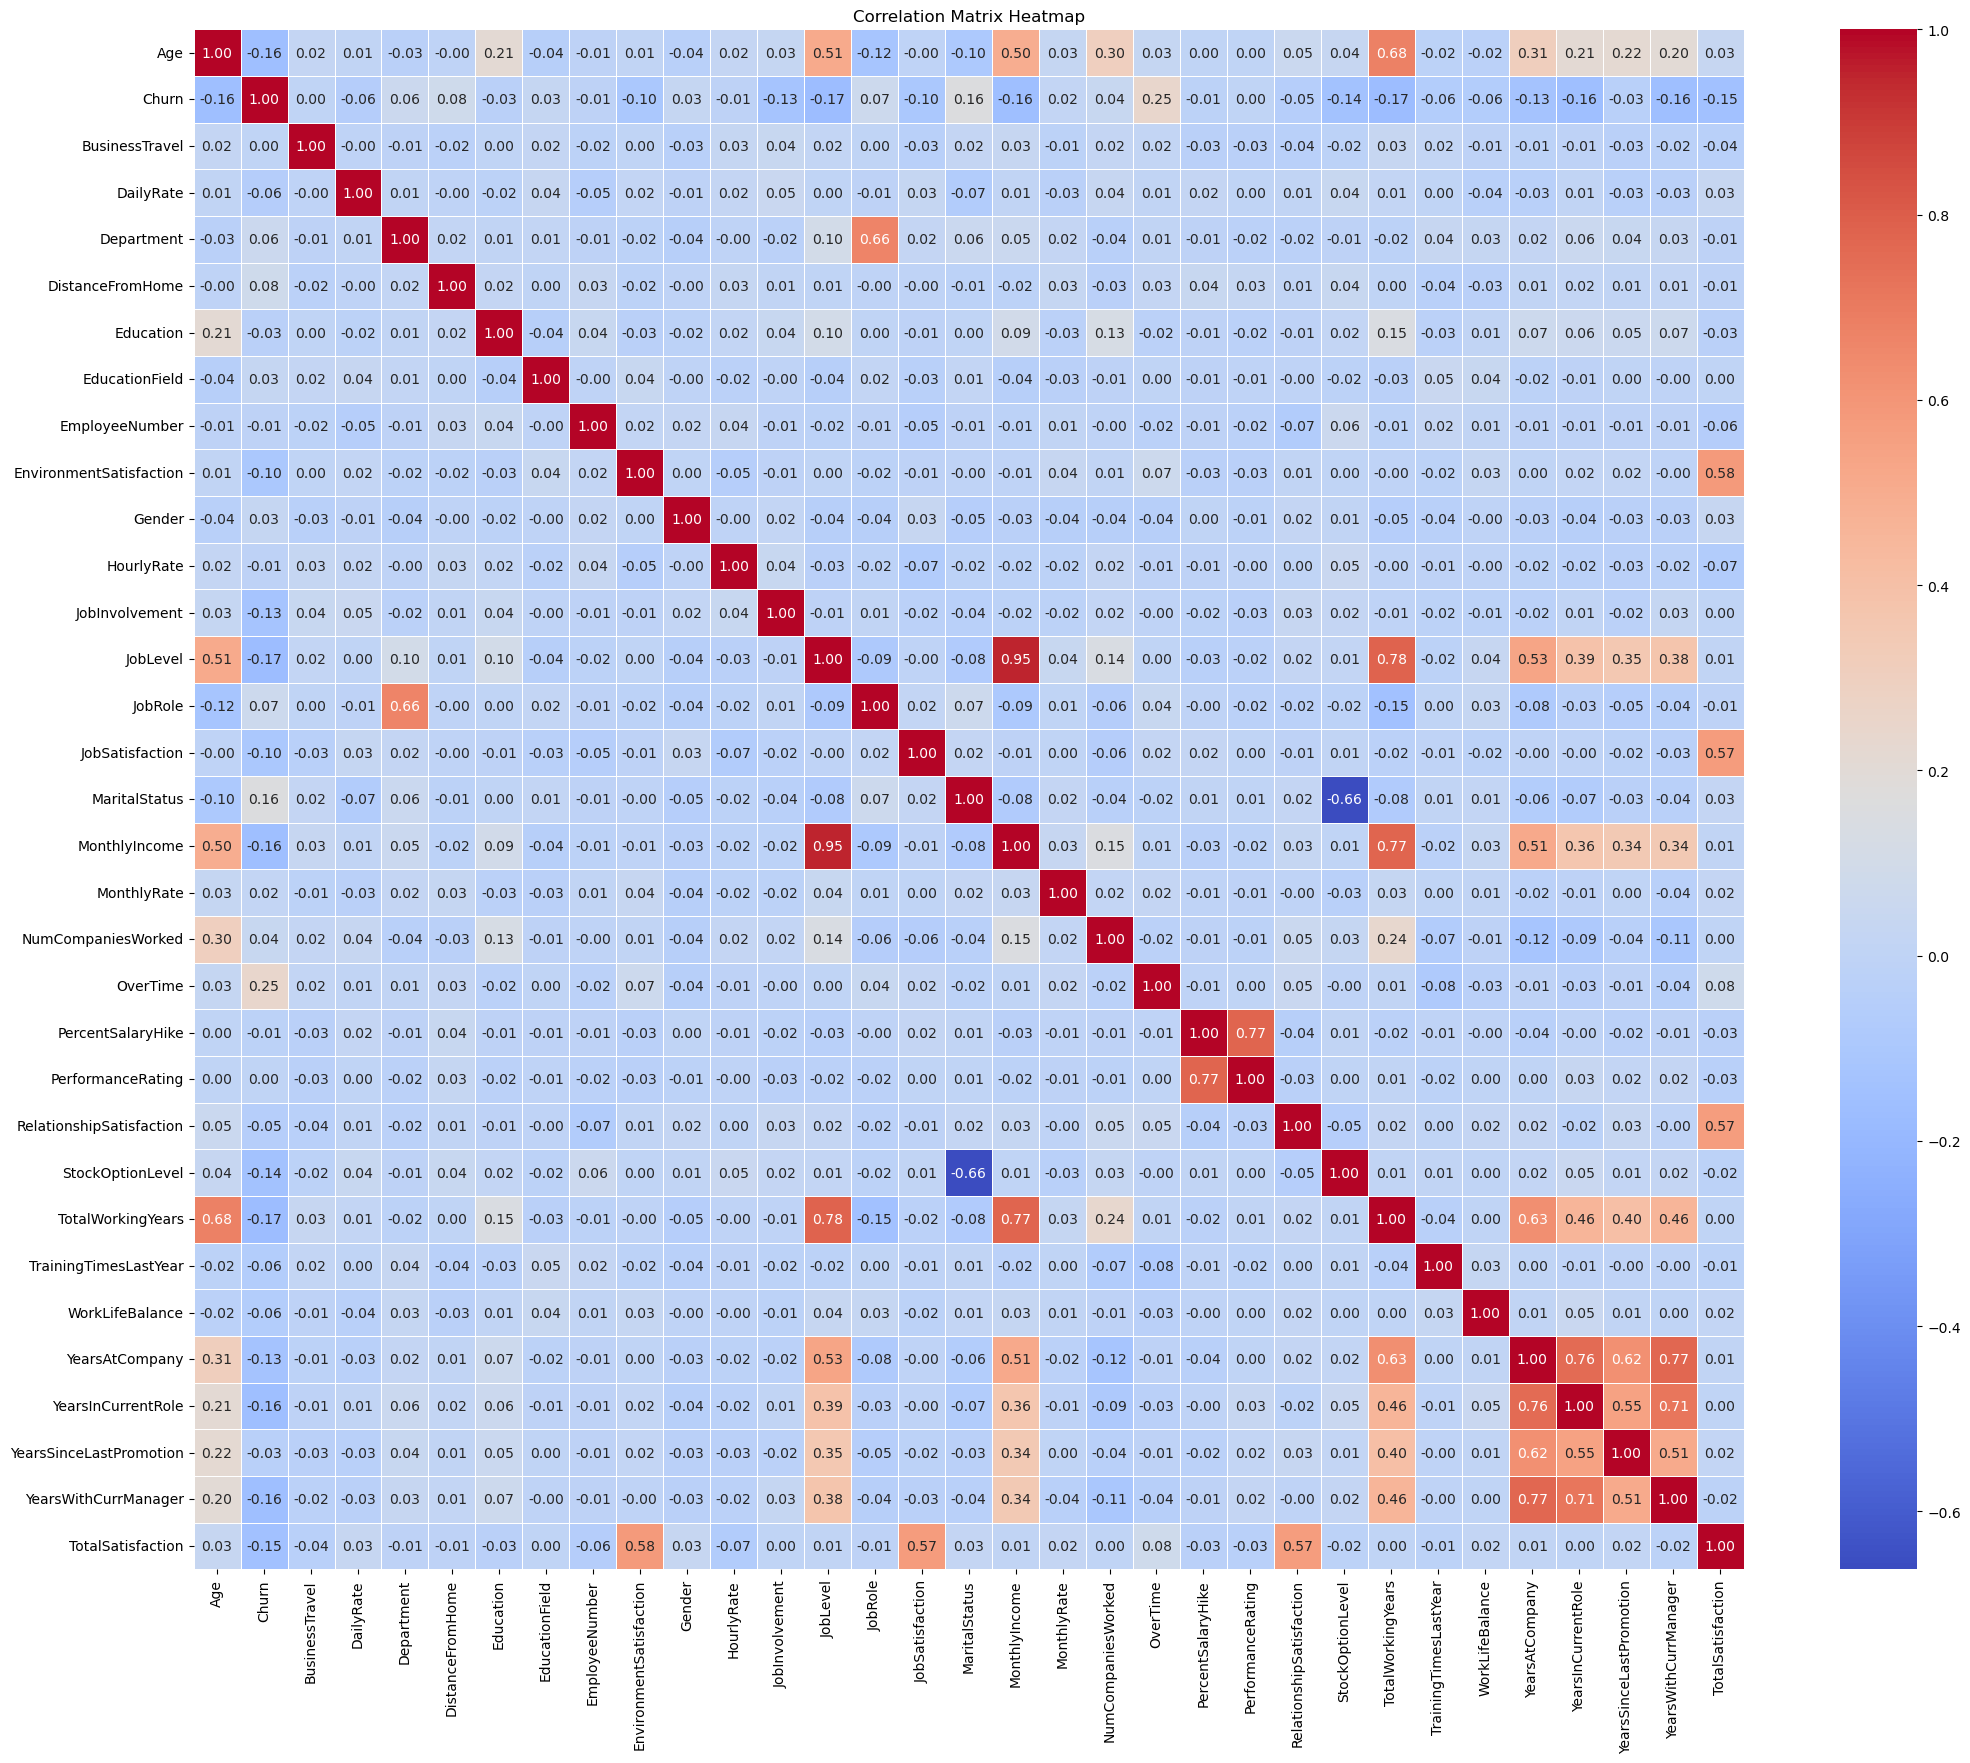

In [15]:
cm = df.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(cm, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'orientation': 'vertical'})
plt.title('Correlation Matrix Heatmap')
plt.show()

Outlier Handling based on a statistical method - Z-score

In [16]:
z_scores = stats.zscore(df[numerical_columns])
threshold = 3
outliers = (abs(z_scores) > threshold).any(axis=1)

print('Before Outlier Shape',df.shape)
df_no_outliers = df[~outliers]
df = df_no_outliers.copy()
print('After Outlier Shape',df.shape)

Before Outlier Shape (1470, 33)
After Outlier Shape (1387, 33)


Dividing the data into training Testing and handling the correlated feature before building a model

In [17]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Removing highly correlated feature which have correlation coefficient of greater than 0.75

In [18]:
print('Before Dropping correlated features training shape size-',X_train.shape)
print('Before Dropping correlated features testing shape size-',X_test.shape)

Before Dropping correlated features training shape size- (1109, 32)
Before Dropping correlated features testing shape size- (278, 32)


In [19]:
highly_correlated = set()
for i in range(len(cm.columns)):
    for j in range(i):
        if abs(cm.iloc[i, j]) > 0.75:
            colname = cm.columns[i]
            highly_correlated.add(colname)

X_train = X_train.drop(highly_correlated, axis=1)
X_test = X_test.drop(highly_correlated, axis=1)

In [20]:
print('After Dropping correlated features training shape size-',X_train.shape)
print('After Dropping correlated features testing shape size-',X_test.shape)

After Dropping correlated features training shape size- (1109, 27)
After Dropping correlated features testing shape size- (278, 27)


In [21]:
X_train.sample(3)

Age  BusinessTravel  DailyRate  Department  DistanceFromHome  \
1009  0.952381               2   0.682176           1          0.000000   
195   0.452381               2   0.134574           1          0.714286   
21    0.428571               2   0.798855           2          0.285714   

      Education  EducationField  EmployeeNumber  EnvironmentSatisfaction  \
1009       0.50               3        0.687954                 1.000000   
195        0.50               1        0.128689                 0.333333   
21         0.75               1        0.012579                 0.666667   

      Gender  ...  NumCompaniesWorked  OverTime  PercentSalaryHike  \
1009       0  ...            0.333333         1           0.714286   
195        1  ...            0.111111         1           0.071429   
21         1  ...            0.777778         0           0.857143   

      RelationshipSatisfaction  StockOptionLevel  TrainingTimesLastYear  \
1009                  0.666667          0.333333               0.500000   
195                   0.000000          0.333333               0.500000   
21                    0.333333          0.000000               0.666667   

      WorkLifeBalance  YearsAtCompany  YearsSinceLastPromotion  \
1009         0.666667           0.225                 0.066667   
195          0.333333           0.200                 0.066667   
21           0.666667           0.125                 0.000000   

      TotalSatisfaction  
1009           0.555556  
195            0.111111  
21             0.333333  

[3 rows x 27 columns]

In [22]:
X_train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'TotalSatisfaction'],
      dtype='object')

Model Building

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

# Load your dataframe
# Assuming your dataframe is named df

# Extract features and target variable
# X = df.drop('Attrition', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Define the XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 8-10 features
selected_features = feature_importance_df.head(10)['Feature'].tolist()

# Print the selected features
print("Selected Features:", selected_features)

# Use SelectFromModel to transform the original data to include only the selected features
sfm = SelectFromModel(xgb_model, threshold=-np.inf, max_features=10)
X_train_selected = sfm.fit_transform(X_train, y_train)
X_test_selected = sfm.transform(X_test)

Selected Features: ['JobLevel', 'OverTime', 'StockOptionLevel', 'TotalSatisfaction', 'WorkLifeBalance', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'JobRole', 'MaritalStatus']


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [26]:
xgb_model = XGBClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

In [27]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 7680 candidates, totalling 38400 fits
Accuracy: 0.841726618705036
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'subsample': 1.0}


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
best_model = XGBClassifier(
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
)

In [29]:
xgb_model_selected = XGBClassifier()
xgb_model_selected.fit(X_train_selected, y_train)

# Make predictions on the test set using the model with selected features
y_pred_selected = xgb_model_selected.predict(X_test_selected)

# Evaluate the model
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print("Accuracy (Selected Features):", accuracy_selected)

# Confusion Matrix
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
print("Confusion Matrix (Selected Features):\n", conf_matrix_selected)

# 

class_report_selected = classification_report(y_test, y_pred_selected)
print("Classification Report (Selected Features):\n", class_report_selected)

Accuracy (Selected Features): 0.8129496402877698
Confusion Matrix (Selected Features):
 [[210  16]
 [ 36  16]]
Classification Report (Selected Features):
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       226
           1       0.50      0.31      0.38        52

    accuracy                           0.81       278
   macro avg       0.68      0.62      0.64       278
weighted avg       0.79      0.81      0.79       278



### Using Cosine Similarity ( Uniqueness of the Model)

In [30]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df['Attrition'].value_counts()
df.fillna(0, inplace=True)

In [31]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [32]:
df['Attrition'].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [33]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [34]:
# df = df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)
df = df.rename(columns={'Attrition': 'Churn'})
df['TotalSatisfaction'] = df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['RelationshipSatisfaction']

# selecting the features for models
features = ['Churn', 'JobLevel', 'OverTime', 'StockOptionLevel', 'TotalSatisfaction', 'WorkLifeBalance',
            'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'JobRole', 'MaritalStatus']

In [35]:
df_subset = df[features]

# using one hot encoding for categorical columns
df_subset_encoded = pd.get_dummies(df_subset, columns=['JobRole', 'MaritalStatus', 'OverTime'])
# subsetting churn 0 and churn 1 datasets
churn_0 = df_subset_encoded[df['Churn'] == 0]
churn_1 = df_subset_encoded[df['Churn'] == 1]
result_df = pd.DataFrame(columns=features + ['CosineSimilarity', 'Churn1Row'])

In [36]:
# function for calculating cosine similarity
def calculate_similarity(row_churn_1, churn_0):
    similarities = cosine_similarity([row_churn_1], churn_0)[0]
    return pd.Series(similarities, index=churn_0.index)

In [37]:
# using for loop for getting into subset of churn 1
for index, row_churn_1 in churn_1.iterrows():
    # calculating cosine similarity with churn 0 subset
    similarities = calculate_similarity(row_churn_1, churn_0)
    result_row = df_subset.loc[index].copy()
    result_row['CosineSimilarity'] = np.nan 
    result_row['Churn1Row'] = index
    result_df = result_df.append(result_row)

    # appending 10 similar cliensts
    top_10_similar_clients = similarities.nlargest(10)
    result_row = df_subset.loc[top_10_similar_clients.index].copy()
    result_row['CosineSimilarity'] = top_10_similar_clients.values
    result_row['Churn1Row'] = index
    result_df = result_df.append(result_row)

C:\Users\rohan\AppData\Local\Temp\ipykernel_23636\2670187746.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_row)
C:\Users\rohan\AppData\Local\Temp\ipykernel_23636\2670187746.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_row)
C:\Users\rohan\AppData\Local\Temp\ipykernel_23636\2670187746.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_row)
C:\Users\rohan\AppData\Local\Temp\ipykernel_23636\2670187746.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_row)
C:\Users\rohan\AppData\Loc

In [38]:
# creating the final results df for potential churners(subset 0) possible based on 
# the cosine similarity score with respect to the actual churners (subset 1)
result_df.reset_index(drop=True, inplace=True)
result_df = result_df[['Churn', 'JobLevel', 'OverTime', 'StockOptionLevel',
       'TotalSatisfaction', 'WorkLifeBalance', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsInCurrentRole', 'JobRole', 'MaritalStatus',
       'CosineSimilarity', 'Churn1Row']]
print(result_df)

     Churn JobLevel OverTime StockOptionLevel TotalSatisfaction  \
0        1        2      Yes                0                 7   
1        0        2      Yes                0                11   
2        0        2       No                0                10   
3        0        3      Yes                1                 9   
4        0        3      Yes                1                 9   
...    ...      ...      ...              ...               ...   
2602     0        5       No                1                10   
2603     0        3      Yes                0                10   
2604     0        4       No                1                11   
2605     0        1      Yes                1                 7   
2606     0        4      Yes                0                 7   

     WorkLifeBalance TotalWorkingYears YearsAtCompany YearsInCurrentRole  \
0                  1                 8              6                  4   
1                  1                11     

In [39]:
result_df.shape

(2607, 13)

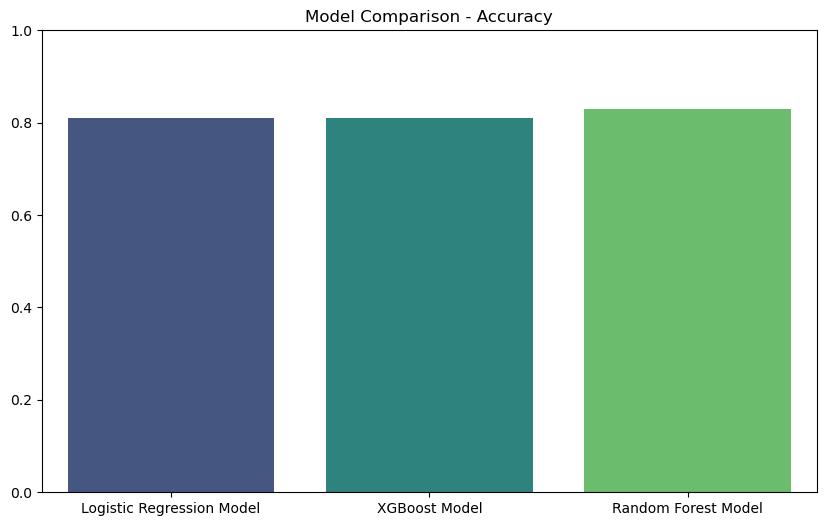

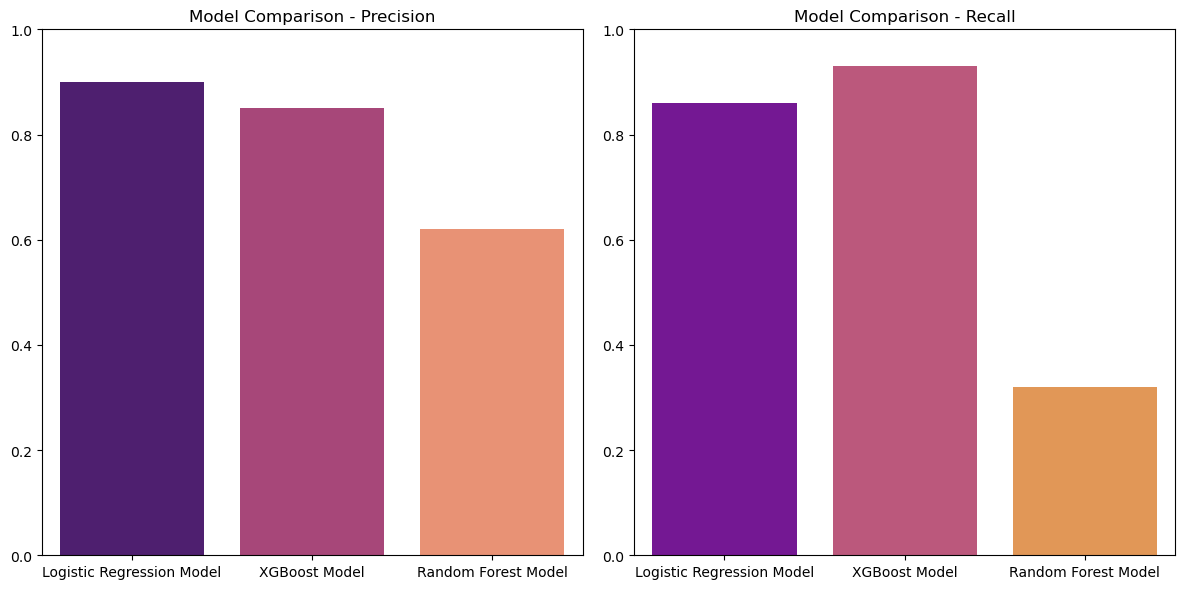

In [41]:
# example of I
models = ['Logistic Regression Model', 'XGBoost Model', 'Random Forest Model']
accuracy_scores = [0.81, 0.81, 0.83]
precision_scores = [0.90, 0.85, 0.62]
recall_scores = [0.86, 0.93, 0.32]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy_scores, palette='viridis')
plt.title('Model Comparison - Accuracy')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=precision_scores, palette='magma')
plt.title('Model Comparison - Precision')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=recall_scores, palette='plasma')
plt.title('Model Comparison - Recall')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
